initial value  1 : [0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1 0 1 0 1 1 0 0 0 1 0 0 1 1 1 1 0 0
 0 0 0 1 0 1 1 1 1 0 1 0 0 1 1 1 1 1 0 0 1 1 0 1 1]
initial value  2 : [0 0 0 1 0 0 1 0 1 0 0 0 1 0 0 0 0 0 0 0 1 0 0 1 0 0 1 0 0 0 0 1 1 0 0 0 0
 1 1 0 0 0 1 1 0 1 1 1 1 0 0 0 1 0 0 0 1 1 1 1 0 1]
initial value  3 : [0 0 1 1 0 0 1 0 0 1 0 0 0 1 1 0 1 1 1 0 1 0 1 1 1 0 0 0 0 1 1 1 1 0 0 0 0
 0 0 1 1 0 1 1 1 0 0 1 1 0 1 1 0 0 1 0 0 0 0 1 1 0]
Minimierer  1 : [20.22770986  5.82269258  1.          1.          1.          1.
  1.          1.          1.          1.          1.          1.
  1.          1.          1.          1.          1.          1.
  1.          1.          0.          1.          1.          1.
  1.          1.          1.          1.          1.          1.
  1.          1.          1.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          1.          

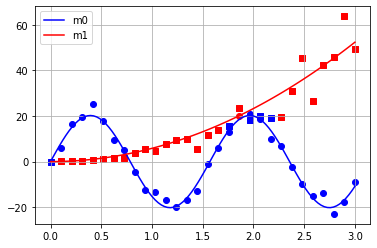

0

In [107]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# Erstellung eines Datensatzes an Messwerten
# Eingabe: Basisfunktionen, Parameterwerte, m = Anzahl der Messwerte, verteilung = zufällige oder gleichmäßige Verteilung der Messpunkte
# fehler = prozentualer Fehler der zu y addiert werden soll, range_x = Anfangs- und Endpunkt der x-Werte

def messwerte(basisfkt1, basisfkt2, parameter1, parameter2, m, verteilung, fehler, range_x):
    if verteilung=='zufällig':
        x1_values=np.random.uniform(range_x[0],range_x[1], size=(m//2))
        x2_values=np.random.uniform(range_x[0],range_x[1], size=(m//2))
    if verteilung=='gleichverteilt':
        x1_values=np.linspace(range_x[0],range_x[1], (m//2))
        x2_values=np.linspace(range_x[0],range_x[1], (m//2))
    x_values=np.concatenate((x1_values, x2_values))
    y_values=np.concatenate((np.dot(parameter1,basisfkt1(x1_values)), np.dot(parameter2,basisfkt2(x2_values))))
    y_values=y_values+fehler*y_values*np.random.randn(m)
    return x_values, y_values

# Input: Basisfunktionen und Messwerte
# enthält m1 = erste Modellfunktion, m2 = zweite Modellfunktion, fkt = Zielfunktion des Minimierugsproblems, df = Ableitung der Zielfunktion

class beispielkonstruktion:
    def __init__(self, basisfkt1, basisfkt2, x_values, y_values):
        self.m=len(x_values)    #Dimension von w
        self.p1=len(basisfkt1(1)) #Dimension von theta1
        self.p2=len(basisfkt2(1)) #Dimension von theta2
        self.p=self.p1+self.p2  #Dimension von theta
        self.x_values=x_values
        self.y_values=y_values
        self.basisfkt1=basisfkt1
        self.basisfkt2=basisfkt2
    
    def m1(self, theta_1, x):
        return np.dot(theta_1,self.basisfkt1(x)) #erstellen der ersten Funktion aus basisfkt1 und parameter1
    
    def m2(self, theta_2, x):
        return np.dot(theta_2,self.basisfkt2(x)) #erstellen der zweiten Funktion aus basisfkt2 und parameter2
    
    
    
    def fkt(self, theta_w): #Erstellung der Zielfunktion 
        theta1=theta_w[:self.p1]
        theta2=theta_w[self.p1:self.p]
        w=theta_w[self.p:]
        f=0
        for i in range(self.m):
            f=f+(w[i])*((np.dot(theta1,self.basisfkt1(self.x_values[i]))-self.y_values[i])**2)+(1-w[i])*((np.dot(theta2,self.basisfkt2(self.x_values[i]))-self.y_values[i])**2)
        return 0.5*f 
    
    def df(self, theta_w): #Ableitung der Zielfunktion
        theta1=theta_w[:self.p1]
        theta2=theta_w[self.p1:self.p]
        w=theta_w[self.p:]
        gradient=[]
        
        for j in range(self.p1): #Ableitung nach theta1
            df=0
            for i in range(self.m):
                df+=w[i]*self.basisfkt1(self.x_values[i])[j]*(np.dot(theta1,self.basisfkt1(self.x_values[i]))-self.y_values[i])
            gradient.append(df) 
        
        for j in range(self.p2): #Ableitung nach theta2
            df=0
            for i in range(self.m):
                df+=(1-w[i])*self.basisfkt2(self.x_values[i])[j]*(np.dot(theta2,self.basisfkt2(self.x_values[i]))-self.y_values[i])
            gradient.append(df)                                                       
        
        for i in range (self.m): #Ableitung nach w
            dfi=0.5*(np.dot(theta1,self.basisfkt1(self.x_values[i]))-self.y_values[i])**2-0.5*(np.dot(theta2,self.basisfkt2(self.x_values[i]))-self.y_values[i])**2
            gradient.append(dfi)
        return gradient

    

def solve(bsp): #Löser für (relaxiertes) Problem, f=Zielfunktion, r gibt an welche Einträge von w fest sind, festgelegten Einträge: 0 oder 1, variable Einträge: 2
    bounds=[]
    for i in range(bsp.p): #keine bounds für theta
        bounds.append((None,None))
    
    for i in range(bsp.m): #bounds für w 
        bounds.append((0,1))

    initial_values=[] #liste  mit drei zufällig gewählten initial values wird erstellt
    for i in range (3): 
        initial_value=np.random.choice([0,1], size=bsp.m+bsp.p)
        print('initial value ', i+1, ':', initial_value)
        initial_values.append(initial_value)
    
    solutions=[] #für jeden initial value wird eine Lösung berechnet
    for i in range (3):
        minimum=minimize(bsp.fkt, initial_values[i], bounds=bounds, jac=bsp.df)
        print('Minimierer ', i+1, ':', minimum.x)
        print('Minimum', i+1, ':', bsp.fkt(minimum.x))
        solutions.append(minimum.x)
    v_opt=min(solutions, key=lambda l: bsp.fkt(l)) #die Lösung mit kleinstem Optimalwert wird bestimmt
    v_opt_theta=v_opt[:bsp.p]
    v_opt_w=v_opt[bsp.p:]
    for i in range (bsp.m): #alle nicht binären Einträge der Lösung werden gleich 0 gesetzt  
        if (v_opt_w[i]%1!=0):
            v_opt_w[i]=0
    v_opt=np.concatenate((v_opt_theta, v_opt_w))
    return v_opt



#plot der beiden Funktionen und der Ausgangswerte mit entsprechender Zuordnung zu Funktionen:

def plot_functions(beispiel, theta_w_optimal):
    
    #plot der optimalen Modellfunktionen:
    def funktion1(x):
        return beispiel.m1(theta_w_optimal[:beispiel.p1], x)

    def funktion2(x):
        return beispiel.m2(theta_w_optimal[beispiel.p1:beispiel.p], x)

    x_values=np.linspace(min(beispiel.x_values), max(beispiel.x_values), 100)
    y1_values=funktion1(x_values)
    y2_values=funktion2(x_values)
    plt.plot(x_values, y1_values, color='blue', label="m0")
    plt.plot(x_values, y2_values, color='red', label="m1")
    
    #plot der Datenpunkte:
    
    x_f1=[]
    y_f1=[] # Punkte, die ursprünglich zu m1 gehört haben und m1 zugeordnet wurden
    x_f2=[]
    y_f2=[] # Punkte, die ursprünglich zu m1 gehört haben und m2 zugeordnet wurden
    x_f3=[]
    y_f3=[] # Punkte, die ursprünglich zu m2 gehört haben und m1 zugeordnet wurden
    x_f4=[]
    y_f4=[] # Punkte, die ursprünglich zu m2 gehört haben und m2 zugeordnet wurden
    
    for i in range (beispiel.m//2):
        if theta_w_optimal[beispiel.p:][i]==1:
            x_f1.append(beispiel.x_values[i])
            y_f1.append(beispiel.y_values[i])
        else:
            x_f2.append(beispiel.x_values[i])
            y_f2.append(beispiel.y_values[i])

    
    for i in range (beispiel.m//2):
        if theta_w_optimal[beispiel.p:][(beispiel.m//2)+i]==1:
            x_f3.append(beispiel.x_values[(beispiel.m//2)+i])
            y_f3.append(beispiel.y_values[(beispiel.m//2)+i])
        else:
            x_f4.append(beispiel.x_values[(beispiel.m//2)+i])
            y_f4.append(beispiel.y_values[(beispiel.m//2)+i])
    plt.scatter(x_f1, y_f1, color='blue', marker='o')
    plt.scatter(x_f2, y_f2, color='red', marker='o')
    plt.scatter(x_f3, y_f3, color='blue', marker='s')
    plt.scatter(x_f4, y_f4, color='red', marker='s')

    plt.legend()
    plt.grid(True)
    plt.show()
    return 0
#Eingabe (falls messdaten gegeben): [basisfunktionen1, basisfunktionen2, x_werte_messdaten, y_werte_messdaten]
#Eingabe (falls messdaten aus modellfunktionen erzeugt werden sollen)[basisfunktionen1, basisfunktionen2, parameter_fkt1, parameter_fkt2, anzahl_messwerte, messwerte 'gleichverteilt' oder 'zufällig', messfehler, Intervall in dem sich x-Werte befinden sollen]
def loesung(bsp_daten):
    if len(bsp_daten)==4:
        Messwerte=[bsp_daten[2],bsp_daten[3]]
    else:
        Messwerte=messwerte(bsp_daten[0],bsp_daten[1],bsp_daten[2],bsp_daten[3],bsp_daten[4],bsp_daten[5],bsp_daten[6],bsp_daten[7])
    Beispiel=beispielkonstruktion(bsp_daten[0],bsp_daten[1],Messwerte[0],Messwerte[1])
    theta_w_optimal=solve(Beispiel)
    print('Lösung:',theta_w_optimal)
    print('Minimalwert:', Beispiel.fkt(theta_w_optimal))
    plot_functions(Beispiel,theta_w_optimal)
    return 0


#Definition des Beispiels aus dem Einführungskapitel:

def basisfkt1_1(x):
    return np.array([np.sin(0.5*x), 1])

def basisfkt2_1(x):
    return np.array([np.sin(0.5*x-1), 1]) 
messwerte_1=[[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14],[2, 17, 41, 59, 80, 89, 90, 68, 57, 43, 12, 4, 2, 11, 16, 55, 85, 96, 118, 110, 93, 74, 56, 23, 12, 11, 16, 36, 58, 84]]
beispiel_einführung=[basisfkt1_1, basisfkt2_1, messwerte_1[0], messwerte_1[1]]

#Definition Beispiel aus kapitel 6.1: verschiedene Initialvektoren

def basisfkt1_2(x):
    return np.array([x, x**2])

def basisfkt2_2(x):
    return np.array([np.sin(x**2), x**3]) 

parameter1_2=np.array([-2, 2])
parameter2_2=np.array([5,3])

beispiel_initialvektoren=[basisfkt1_2, basisfkt2_2, parameter1_2, parameter2_2, 20, 'gleichverteilt', 0, [0,3]]

#Definition Beispiel aus kapitel 6.2: Einfluss Messfehler

def basisfkt1_3(x):
    return np.array([np.sin(4*x)])

def basisfkt2_3(x):
    return np.array([x**2])

parameter1_3=np.array([20])
parameter2_3=np.array([5])

beispiel_messfehler=[basisfkt1_3, basisfkt2_3, parameter1_3, parameter2_3, 60, 'gleichverteilt', 0.2, [0,3]]

#loesung(beispiel_einführung)
#loesung(beispiel_initialvektoren)
loesung(beispiel_messfehler)

In [1]:
import os
os.getcwd()

'/Users/rebekka'

[50.94214315 59.04779422]


<ipython-input-99-0c3f3712cf1e>:41: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array([np.sin(0.5*x), 1])


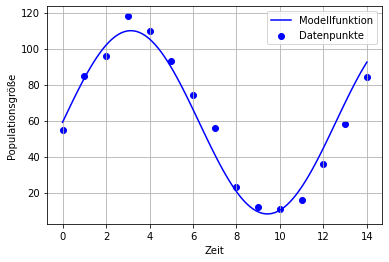

0

In [99]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

class beispielkonstruktion:
    def __init__(self, basisfkt, x_values, y_values):
        self.m=len(x_values)    #Dimension von w
        self.p=len(basisfkt(1)) #Dimension von theta1
        self.x_values=x_values
        self.y_values=y_values
    
    def m(self, theta, x):
        return np.dot(theta,basisfkt(x)) #erstellen der ersten Funktion aus basisfkt1 und parameter1
    
    
    def fkt(self, theta): #Erstellung der Zielfunktion 
        f=0
        for i in range(self.m):
            f=f+(np.dot(theta,basisfkt(self.x_values[i]))-self.y_values[i])**2
        return 0.5*f 
    
def plot_functions(beispiel, thetaoptimal):
    def f(x):
        return np.dot(thetaoptimal,basisfkt(x))
        
    x_values=np.linspace(min(beispiel.x_values), max(beispiel.x_values), 100)
    #print(x_values)
    y1_values=f(x_values)
    #print(y1_values)
    plt.plot(x_values, y1_values, color='blue', label="Modellfunktion")
    plt.scatter(beispiel.x_values, beispiel.y_values, color='blue', marker='o', label="Datenpunkte")
    plt.legend()
    plt.xlabel('Zeit')
    plt.ylabel('Populationsgröße')
    plt.grid(True)
    plt.show()
    return 0
    
    
def basisfkt(x):
    return np.array([np.sin(0.5*x), 1])
  

parameter=np.array([50, 60])


#messwerte=messwerte(basisfkt1, basisfkt2, parameter1, parameter2, 30, 'gleichmäßig', 0, [0,14])
messwerte=[[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14],[55, 85, 96, 118, 110, 93, 74, 56, 23, 12, 11, 16, 36, 58, 84]]
bsp=beispielkonstruktion(basisfkt, messwerte[0], messwerte[1])
initialvalue=[]
for i in range(bsp.p):
        initialvalue.append(0)

minimum=minimize(bsp.fkt, initialvalue)
print(minimum.x)
plot_functions(bsp, minimum.x)


NameError: name 'git' is not defined